In [2]:
%pip install pyspark


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

print(spark.sparkContext)
print("Spark App Name: " + spark.sparkContext.appName)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/27 21:36:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<SparkContext master=local[*] appName=pyspark-shell>
Spark App Name: pyspark-shell


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49742)
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/pruthvipatel/Library/Python/3.9/lib/py

**Loading dataset**


In [2]:
df = spark.read.csv("Datasets/olist_order_reviews_dataset.csv",
                    header=True, inferSchema=True)
df.show(5)

24/06/27 21:37:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                NULL|                  NULL| 2018-01-18 00:00:00|    2018-01-18 21:46:59|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                NULL|                  NULL| 2018-03-10 00:00:00|    2018-03-11 03:05:13|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                NULL|                  NULL| 2018-02-17 00:00:00|    2018-02-18 14:36:24|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|                NULL|  Recebi bem antes ...| 2017-04-21 00:00:00|   

In [3]:
columns = df.columns
print("Column Names: ", columns)

Column Names:  ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


**Checking Null Values**


In [4]:
from pyspark.sql.functions import col, sum
null_counts = df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---------+--------+------------+--------------------+----------------------+--------------------+-----------------------+
|review_id|order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|
+---------+--------+------------+--------------------+----------------------+--------------------+-----------------------+
|        1|    2236|        2380|               92157|                 63079|                8764|                   8785|
+---------+--------+------------+--------------------+----------------------+--------------------+-----------------------+



In [5]:
row_count = df.count()
print("Number of rows: ", row_count)

Number of rows:  104162


In [6]:
df_comments = df.select(
    ["review_id", 'review_score', 'review_comment_message'])
df_comments = df_comments.filter(col('review_comment_message').isNotNull())

df_comments = df_comments.withColumnRenamed('review_score', 'score') \
                         .withColumnRenamed('review_comment_message', 'comment')

num_rows = df_comments.count()
num_columns = len(df_comments.columns)
print(f'Dataset shape: ({num_rows}, {num_columns})')

df_comments.show(5)

Dataset shape: (41083, 3)
+--------------------+-----+--------------------+
|           review_id|score|             comment|
+--------------------+-----+--------------------+
|e64fb393e7b32834b...|    5|Recebi bem antes ...|
|f7c4243c7fe1938f1...|    5|Parabéns lojas la...|
|8670d52e15e00043a...|    4|aparelho eficient...|
|4b49719c8a200003f...|    4|Mas um pouco ,tra...|
|3948b09f7c818e2d8...|    5|Vendedor confiáve...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [7]:
# check for null values
null_counts = df_comments.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df_comments.columns])
null_counts.show()

+---------+-----+-------+
|review_id|score|comment|
+---------+-----+-------+
|        1|    0|      0|
+---------+-----+-------+



Text Processing


Text Conversion


In [8]:
from pyspark.sql.functions import col, regexp_replace


def re_money(df, column_name):
    pattern = r'[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return df.withColumn(column_name, regexp_replace(col(column_name), pattern, ' dinheiro '))


df_transformed = re_money(df_comments, 'comment')
df_transformed.show(truncate=False)

+--------------------------------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id                       |score|comment                                                                                                                                                                       |
+--------------------------------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|e64fb393e7b32834bb789ff8bb30750e|5    |Recebi bem antes do prazo estipulado.                                                                                                                                         |
|f7c4243c7fe1938f181bec41a392bdeb|5    |Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Pá

In [9]:
from pyspark.sql.functions import col, lower, explode, split


def find_sentences_with_dinheiro(df, column_name):
    df = df.withColumn('sentences', split(col(column_name), '[.]'))

    df = df.withColumn('sentence', explode(col('sentences')))

    df_with_dinheiro = df.filter(lower(col('sentence')).like('% dinheiro %'))

    return df_with_dinheiro


df_sentences_with_dinheiro = find_sentences_with_dinheiro(
    df_comments, 'comment')

df_sentences_with_dinheiro.select('comment', 'sentences').show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|comment                                                                                                                                                                                                   |sentences                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
from pyspark.sql import functions as F


def clean_text(text):
    if text is None:
        return None
    # Remove URLs
    text = F.regexp_replace(text, r'http\S+|www\S+|https\S+', '')
    # Remove dates (example: 2024-06-25, 25/06/2024, etc.)
    text = F.regexp_replace(text, r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b', '')
    # Remove numbers
    text = F.regexp_replace(text, r'\b\d+\b', '')
    # Remove special characters except spaces
    text = F.regexp_replace(text, r'[^A-Za-z\s]', '')
    # Remove extra whitespace
    text = F.trim(F.regexp_replace(text, r'\s+', ' '))
    return text


def clean_text_column(df, column_name):
    return df.withColumn(column_name, clean_text(F.col(column_name)))


df_cleaned = clean_text_column(df_transformed, 'comment')
df_cleaned.show(5)

+--------------------+-----+--------------------+
|           review_id|score|             comment|
+--------------------+-----+--------------------+
|e64fb393e7b32834b...|    5|Recebi bem antes ...|
|f7c4243c7fe1938f1...|    5|Parabns lojas lan...|
|8670d52e15e00043a...|    4|aparelho eficient...|
|4b49719c8a200003f...|    4|Mas um pouco trav...|
|3948b09f7c818e2d8...|    5|Vendedor confivel...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [11]:
def re_negation(df, column_name):
    pattern = r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )'
    return df.withColumn(column_name, regexp_replace(col(column_name), pattern, ' negação '))


df_with_replaced_negations = re_negation(df_cleaned, 'comment')

# df_with_replaced_negations.select('comment').show(truncate=False)
df_with_replaced_negations.show(truncate=False)

+--------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id                       |score|comment                                                                                                                                                                |
+--------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|e64fb393e7b32834bb789ff8bb30750e|5    |Recebi bem antes do prazo estipulado                                                                                                                                   |
|f7c4243c7fe1938f181bec41a392bdeb|5    |Parabns lojas lannister adorei comprar pela Internet seguro e prtico Parabns a todos feliz Pscoa                            

In [12]:
processed_df = df_with_replaced_negations.select(
    "review_id", 'score', 'comment')
processed_df.show(5)

+--------------------+-----+--------------------+
|           review_id|score|             comment|
+--------------------+-----+--------------------+
|e64fb393e7b32834b...|    5|Recebi bem antes ...|
|f7c4243c7fe1938f1...|    5|Parabns lojas lan...|
|8670d52e15e00043a...|    4|aparelho eficient...|
|4b49719c8a200003f...|    4|Mas um pouco trav...|
|3948b09f7c818e2d8...|    5|Vendedor confivel...|
+--------------------+-----+--------------------+
only showing top 5 rows



**Removing Stopwards**


In [12]:
!pip install nltk


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pruthvipatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.corpus import stopwords

stop_words = set(stopwords.words('portuguese'))


def remove_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)


remove_stopwords = udf(remove_stopwords, StringType())

stopwords_free_df = processed_df.withColumn(
    'comment_cleaned', remove_stopwords('comment'))

stopwords_free_df.show(truncate=False)

+--------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+
|review_id                       |score|comment                                                                                                                                                                |comment_cleaned                                                                                                                  |
+--------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pruthvipatel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

porter = PorterStemmer()


def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [porter.stem(word) for word in words]
    return ' '.join(stemmed_words)


stem_text = udf(stem_text, StringType())

stemmed_df = stopwords_free_df.withColumn(
    'comment_stemmed', stem_text('comment_cleaned'))

stemmed_df.show(truncate=False)

+--------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+
|review_id                       |score|comment                                                                                                                                                                |comment_cleaned                                                                                                                  |comment_stemmed                                                                                                            |
+--------------------------------+-----+----------------------------------

**Feature Extraction**


**CountVectorizer**


In [16]:
from pyspark.ml.feature import CountVectorizer, Tokenizer

vec_df = stemmed_df.select("review_id", "comment_stemmed", "score")

tokenizer = Tokenizer(inputCol="comment_stemmed", outputCol="words")
df_words = tokenizer.transform(vec_df)

cv = CountVectorizer(inputCol="words", outputCol="features",
                     vocabSize=15000, minDF=1.0)
cv_model = cv.fit(df_words)
df_features = cv_model.transform(df_words)

df_features.show(truncate=False)

+--------------------------------+---------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+
|review_id                       |comment_stemmed                                                                                                            |score|words                                                                                                                                          |features                                                                                                                        |
+--------------------------------+------------------------------------------------------------------------------------------

In [17]:
# write code to import explode
from pyspark.sql.functions import explode
unique_tokens_count = df_words.select(
    explode("words").alias("token")).select("token").distinct().count()
unique_tokens_count

14989

**TF-IDF**


In [18]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

hashingTF = HashingTF(
    inputCol="words", outputCol="rawFeatures", numFeatures=262144)
tf_features = hashingTF.transform(df_words)

# IDF calculation
idf = IDF(inputCol="rawFeatures", outputCol="tfidf_features")
idf_model = idf.fit(tf_features)
tfidf_features = idf_model.transform(tf_features)

# Show the TF-IDF features
tfidf_features.show(truncate=False)

24/06/27 21:38:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------------------+---------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id                       |comment_stemmed                                                    

**Adding Label**


In [19]:
def create_label(rating_score):

    if rating_score in ["1", "2", "3"]:
        return "negative"
    elif rating_score in ["4", "5"]:
        return "positive"
    else:
        return "unknown"


label = udf(create_label, StringType())

df_with_label = tfidf_features.withColumn("label", label(col("score")))

df_with_label.show()

24/06/27 21:38:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------+
|           review_id|     comment_stemmed|score|               words|         rawFeatures|      tfidf_features|   label|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------+
|e64fb393e7b32834b...|recebi bem ant pr...|    5|[recebi, bem, ant...|(262144,[21796,33...|(262144,[21796,33...|positive|
|f7c4243c7fe1938f1...|parabn loja lanni...|    5|[parabn, loja, la...|(262144,[21295,46...|(262144,[21295,46...|positive|
|8670d52e15e00043a...|aparelho eficient...|    4|[aparelho, eficie...|(262144,[14124,59...|(262144,[14124,59...|positive|
|4b49719c8a200003f...|pouco travandopel...|    4|[pouco, travandop...|(262144,[30163,10...|(262144,[30163,10...|positive|
|3948b09f7c818e2d8...|vendedor confivel...|    5|[vendedor, confiv...|(262144,[1643,217...|(262144,[1643,217...|positive|
|9314d6f9799f5bfba...|go

**Model Development**


In [20]:
from pyspark.sql.functions import when

df_with_label = df_with_label.withColumn("label_numeric", when(
    df_with_label.label == "positive", 1).otherwise(0))

# Show the result
df_with_label.show()

24/06/27 21:39:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------+-------------+
|           review_id|     comment_stemmed|score|               words|         rawFeatures|      tfidf_features|   label|label_numeric|
+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------+-------------+
|e64fb393e7b32834b...|recebi bem ant pr...|    5|[recebi, bem, ant...|(262144,[21796,33...|(262144,[21796,33...|positive|            1|
|f7c4243c7fe1938f1...|parabn loja lanni...|    5|[parabn, loja, la...|(262144,[21295,46...|(262144,[21295,46...|positive|            1|
|8670d52e15e00043a...|aparelho eficient...|    4|[aparelho, eficie...|(262144,[14124,59...|(262144,[14124,59...|positive|            1|
|4b49719c8a200003f...|pouco travandopel...|    4|[pouco, travandop...|(262144,[30163,10...|(262144,[30163,10...|positive|            1|
|3948b09f7c818e2d8...|vendedor confivel...|    5

In [22]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession



# Assuming df_with_label contains the relevant columns
selected_columns = ['tfidf_features', 'label_numeric']
df_selected = df_with_label.select(selected_columns)

# Define classifiers
lr = LogisticRegression(featuresCol='tfidf_features', labelCol='label_numeric')
nb = NaiveBayes(featuresCol='tfidf_features', labelCol='label_numeric')
svm = LinearSVC(featuresCol='tfidf_features', labelCol='label_numeric')

# Store classifiers and their names
classifiers = {
    'LogisticRegression': lr,
    'NaiveBayes': nb,
    'LinearSVC': svm
}

# Dictionary to store trained models
trained_models = {}
results = {}

# Train and store models
for name, classifier in classifiers.items():
    print(f"Training model: {name}")

    # Train model
    model = classifier.fit(df_selected)

    # Store trained model
    trained_models[name] = model

    # Make predictions
    predictions = model.transform(df_selected)

    # Evaluate accuracy (can add more evaluation metrics here)
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label_numeric', predictionCol='prediction', metricName='accuracy')
    accuracy = evaluator.evaluate(predictions)

    # Store results
    results[name] = accuracy


# Print results
for name, accuracy in results.items():
    print(f"Model: {name}, Accuracy: {accuracy}")

Training model: LogisticRegression


24/06/27 21:39:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:39:36 WARN DAGScheduler: Broadcasting larg

Training model: NaiveBayes


24/06/27 21:40:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:23 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


Training model: LinearSVC


24/06/27 21:40:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/27 21:40:43 WARN DAGScheduler: Broadcasting larg

Model: LogisticRegression, Accuracy: 0.9453301852347686
Model: NaiveBayes, Accuracy: 0.9071635469658983
Model: LinearSVC, Accuracy: 0.944867706837378


24/06/27 21:41:22 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/06/27 21:41:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


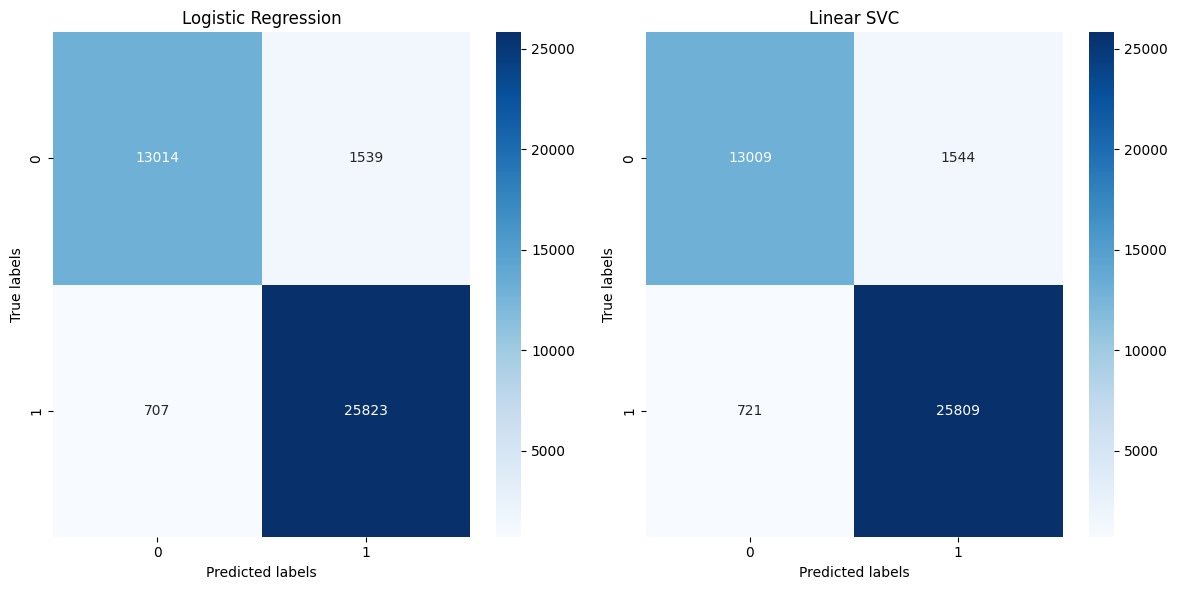

In [23]:
# plot conufstion matrix for logistic regression and linear svc

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get predictions
lr_predictions = trained_models['LogisticRegression'].transform(df_selected)
svm_predictions = trained_models['LinearSVC'].transform(df_selected)

# Convert predictions to pandas dataframe

lr_predictions_converted = lr_predictions.select(
    'label_numeric', 'prediction').toPandas()
svm_predictions_converted = svm_predictions.select(
    'label_numeric', 'prediction').toPandas()

# Create confusion matrix
lr_cm = confusion_matrix(
    lr_predictions_converted['label_numeric'], lr_predictions_converted['prediction'])
svm_cm = confusion_matrix(
    svm_predictions_converted['label_numeric'], svm_predictions_converted['prediction'])

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Logistic Regression
sns.heatmap(pd.DataFrame(lr_cm), annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Logistic Regression')


# Linear SVC
sns.heatmap(pd.DataFrame(svm_cm), annot=True, fmt='g', cmap='Blues', ax=ax[1])
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Linear SVC')

plt.tight_layout()
plt.show()

**Finalise Model Metrics**


In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate precision, recall, and f1 score for Logistic Regression
evaluator = MulticlassClassificationEvaluator(
    labelCol='label_numeric', predictionCol='prediction', metricName='weightedPrecision')
precision = evaluator.evaluate(lr_predictions)

evaluator = MulticlassClassificationEvaluator(
    labelCol='label_numeric', predictionCol='prediction', metricName='weightedRecall')
recall = evaluator.evaluate(lr_predictions)

evaluator = MulticlassClassificationEvaluator(
    labelCol='label_numeric', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(lr_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

24/06/27 21:28:27 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/27 21:28:36 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/06/27 21:28:43 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


Precision: 0.9454257535834862
Recall: 0.9453301852347686
F1 Score: 0.9449478233448336


**ROC and AUC**


24/06/27 21:28:57 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


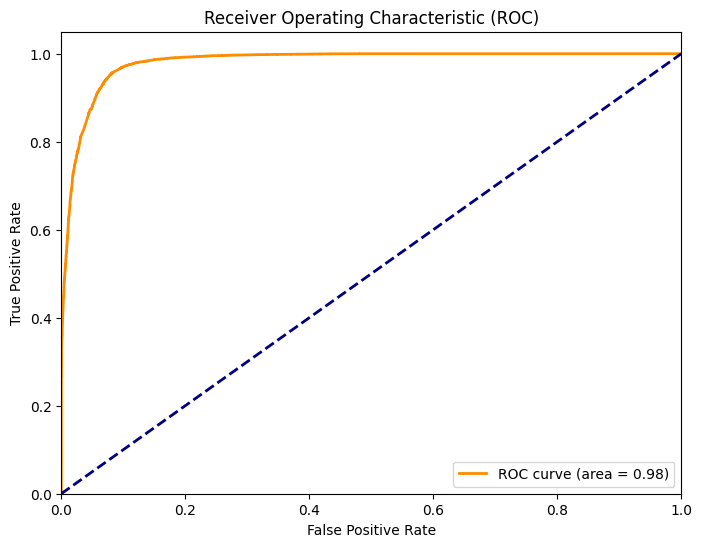

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


lr_prob = trained_models['LogisticRegression'].transform(df_selected)
lr_prob = lr_prob.select('label_numeric', 'probability').toPandas()


fpr, tpr, threshold = roc_curve(
    lr_prob['label_numeric'], lr_prob['probability'].apply(lambda x: x[1]))


roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

**Preparing Final Dataset for Export**


In [24]:
df_filtered = df.join(df_comments, on='review_id', how='inner')
df_filtered.show(5)

# check rows

df_filtered.count()

+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+-----+--------------------+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|score|             comment|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+-----+--------------------+
|e64fb393e7b32834b...|658677c97b385a9be...|           5|                NULL|  Recebi bem antes ...| 2017-04-21 00:00:00|    2017-04-21 22:02:06|    5|Recebi bem antes ...|
|f7c4243c7fe1938f1...|8e6bfb81e283fa7e4...|           5|                NULL|  Parabéns lojas la...| 2018-03-01 00:00:00|    2018-03-02 10:26:53|    5|Parabéns lojas la...|
|8670d52e15e00043a...|b9bf720beb4ab3728...|           4|           recomendo|  aparelho eficient...| 2018-05-22 00:00:00|    2018-05-23

41734

In [38]:
df_filtered = df_filtered.drop('review_score', 'review_comment_message', 'comment')


df_with_label_selected = df_with_label.select('review_id', 'label')

df_joined = df_filtered.join(
    df_with_label_selected, on='review_id', how='inner')

# gett comment friled from tfidf_features
features_from_tfidf = df_with_label.select('review_id', 'comment_stemmed')

# join the two dataframes
df_joined = df_joined.join(features_from_tfidf, on='review_id', how='inner')



# rename comment stemmed to comment
df_joined = df_joined.withColumnRenamed('comment_stemmed', 'comment')

df_joined.show(5)

+--------------------+--------------------+--------------------+--------------------+-----------------------+-----+--------+--------------------+
|           review_id|            order_id|review_comment_title|review_creation_date|review_answer_timestamp|score|   label|             comment|
+--------------------+--------------------+--------------------+--------------------+-----------------------+-----+--------+--------------------+
|e64fb393e7b32834b...|658677c97b385a9be...|                NULL| 2017-04-21 00:00:00|    2017-04-21 22:02:06|    5|positive|recebi bem ant pr...|
|f7c4243c7fe1938f1...|8e6bfb81e283fa7e4...|                NULL| 2018-03-01 00:00:00|    2018-03-02 10:26:53|    5|positive|parabn loja lanni...|
|8670d52e15e00043a...|b9bf720beb4ab3728...|           recomendo| 2018-05-22 00:00:00|    2018-05-23 16:45:47|    4|positive|aparelho eficient...|
|4b49719c8a200003f...|9d6f15f95d01e79bd...|                NULL|                NULL|                   NULL|    4|positive|

**Data Loading to My SQL**


In [ ]:
# Import necessary libraries
from sqlalchemy import create_engine


# Assuming df_joined is your Spark DataFrame
df_pandas = df_joined.toPandas()

# Database connection details
database_name = "olist_data"
table_name = "order_reviews"
username = "root"
password = "pruthvi12"
host = "localhost"
port = "3306"

# Create SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database_name}')

# Load data into MySQL using Pandas
df_pandas.to_sql(name=table_name, con=engine, if_exists='replace', index=False)

print("Data loaded successfully into MySQL!")


Data loaded successfully into MySQL!


24/06/28 04:34:52 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1023474 ms exceeds timeout 120000 ms
24/06/28 04:34:53 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/28 04:34:55 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 